# Volcano Plot

In [1]:
import numpy as np
import pandas as pd
import anndata as ad
from scipy.sparse import csr_matrix
from scipy.sparse import issparse
import scanpy as sc
import scipy.stats
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import seaborn as sns
print(ad.__version__)

0.11.4


In [2]:
# There are 9 excel files in the folder results
# The excel files have two collumns: 'Gene' and 'Number of Significant Differences'

# The excel files are named: "results/{}_significant_differences.xlsx".format(cell_type)
cell_types = [
    # "CD8-positive, alpha-beta T cell",
    "CD8-positive, alpha-beta memory T cell",
    "CD4-positive, alpha-beta T cell",
    "central memory CD4-positive, alpha-beta T cell",
    "effector memory CD4-positive, alpha-beta T cell",
    "gamma-delta T cell",
    "regulatory T cell",
    # "double negative T regulatory cell",
    # "innate lymphoid cell"
]

adata = ad.read_h5ad("../h5ad/0fce5dd5-bcec-4288-90b3-19a16b45ad16.h5ad", backed='r')

In [3]:
# Load all the excel files of the same cell type

excel_files_top_diff_genes = {}

for cell_type in cell_types:
    file_path = f"results/{cell_type}_top_diff_genes.xlsx"
    excel_files_top_diff_genes[cell_type] = pd.read_excel(file_path)


In [4]:
# Create a volcano plot for each cell type
# On the x-axis: is the difference between 'Correlation Young' and 'Correlation Old'
# On the y-axis: is the -log10 of the p-value

def z_score_to_p_value(z):
    """Convert a z-score to a p-value. for a two-tailed test."""
    return 2 * (1 - scipy.stats.norm.cdf(np.abs(z)))


def create_volcano_plot(df, cell_type):
    df['log_p_value_1'] = -np.log10(z_score_to_p_value(df['Z Diff Young-Middle']))
    df['log_p_value_2'] = -np.log10(z_score_to_p_value(df['Z Diff Middle-Old']))
    df['log_p_value_3'] = -np.log10(z_score_to_p_value(df['Z Diff Young-Old']))
    df['log_p_value'] = df[['log_p_value_1', 'log_p_value_2', 'log_p_value_3']].min(axis=1)
    # df['log_p_value'] = -np.log10(z_score_to_p_value(df['Z Diff Middle-Old']))
    df['Significant'] = df['log_p_value'] > -np.log10(0.01)

    df['correlation_diff_1'] = df['Correlation Young'] - df['Correlation Middle']
    df['correlation_diff_2'] = df['Correlation Middle'] - df['Correlation Old']
    df['correlation_diff_3'] = df['Correlation Young'] - df['Correlation Old']

    # Take the minimum of the two correlation differences based on the absolute value without changing the sign
    # df['correlation_diff'] = np.where(np.abs(df['correlation_diff_1']) < np.abs(df['correlation_diff_2']), 
    #                                   df['correlation_diff_1'], 
    #                                   df['correlation_diff_2'])
    df['correlation_diff_temp'] = np.where(np.abs(df['correlation_diff_1']) < np.abs(df['correlation_diff_2']),
                                            df['correlation_diff_1'], 
                                            df['correlation_diff_2'])
    df['correlation_diff'] = np.where(np.abs(df['correlation_diff_temp']) < np.abs(df['correlation_diff_3']),
                                            df['correlation_diff_temp'], 
                                            df['correlation_diff_3'])
    # df['correlation_diff'] = df[['correlation_diff_1', 'correlation_diff_2']].min(axis=1)
    # df['correlation_diff'] = df['Correlation Middle'] - df['Correlation Old']
    
    plt.figure(figsize=(10, 6))
    sns.scatterplot(data=df, x='correlation_diff', y='log_p_value', hue='Significant', alpha=0.7)
    
    plt.axhline(y=-np.log10(0.01), color='red', linestyle='--', label='p-value = 0.01')
    plt.axvline(x=0, color='grey', linestyle='--')
    
    plt.title(f'Volcano Plot for {cell_type}')
    plt.xlabel('Minimum Correlation Difference (Young-Middle or Middle-Old or Young-Old)')
    plt.ylabel('Minimum -log10(p-value)')
    plt.legend()
    plt.grid()

    # add labels for the points that have a -log10(p-value) > 0.9 * max(log_p_value)
    max_log_p_value = df['log_p_value'].max()
    threshold = 0.9 * max_log_p_value
    for i, row in df.iterrows():
        if row['log_p_value'] > threshold and (i % 2 == 0):
            gene_1 = row['Gene1']
            feature_1 = (adata.var['feature_name'][gene_1]).split('_')[0]
            gene_2 = row['Gene2']
            feature_2 = (adata.var['feature_name'][gene_2]).split('_')[0]
            label = feature_1 + '-' + feature_2
            print(f"Labeling point: {label} at ({row['correlation_diff']}, {row['log_p_value']})")

            # If the point is left of the y-axis, adjust the label position
            if row['correlation_diff'] < 0:
                plt.text(row['correlation_diff'], row['log_p_value'], label, fontsize=8, ha='left', va='bottom')
            else:
                plt.text(row['correlation_diff'], row['log_p_value'], label, fontsize=8, ha='right', va='bottom')
    
    plt.savefig(f"results/volcano_plot_{cell_type}.png")
    plt.close()



In [5]:
for cell_type, df in excel_files_top_diff_genes.items():
    # Ensure the DataFrame has the expected columns
    if 'Correlation Young' in df.columns and 'Correlation Old' in df.columns:
        create_volcano_plot(df, cell_type)
    else:
        print(f"Skipping {cell_type} due to missing columns.")

Labeling point: MYH9-PNRC1 at (0.24765211376642737, 4.03076232569693)
Labeling point: TNFAIP3-NFKBIA at (0.07824048007595108, 4.0041539478607415)
Labeling point: NFKBIA-NR4A2 at (0.06351035834829932, 4.152461944620706)
Labeling point: RPL7-PCBP2 at (-0.4634154961585426, 3.2473392322150274)
Labeling point: RPL23-PCBP2 at (-0.43900041218812813, 3.2287617456087827)
Labeling point: UBE2D3-ARHGEF1 at (0.4998478395538947, 4.649128239207923)
Labeling point: FLNA-ANAPC16 at (-0.41963036537673115, 4.363755218308162)
Labeling point: RPL21-LIME1 at (0.4607472898373074, 4.318040963688329)
Labeling point: UBE2D3-RBL2 at (0.5329826018713602, 4.4102517023119745)
Labeling point: SERF2-FLNA at (-0.37890084509038596, 4.516214446490147)
Labeling point: MYH9-CD3D at (-0.37798167265713006, 4.384938298077186)
Labeling point: RBL2-OAZ1 at (-0.468512177603186, 4.3536979557506665)
Labeling point: MYL12A-MYH9 at (-0.33365103495484394, 4.790666061685027)
Labeling point: RAC2-RBL2 at (-0.4770104081451041, 4.32593

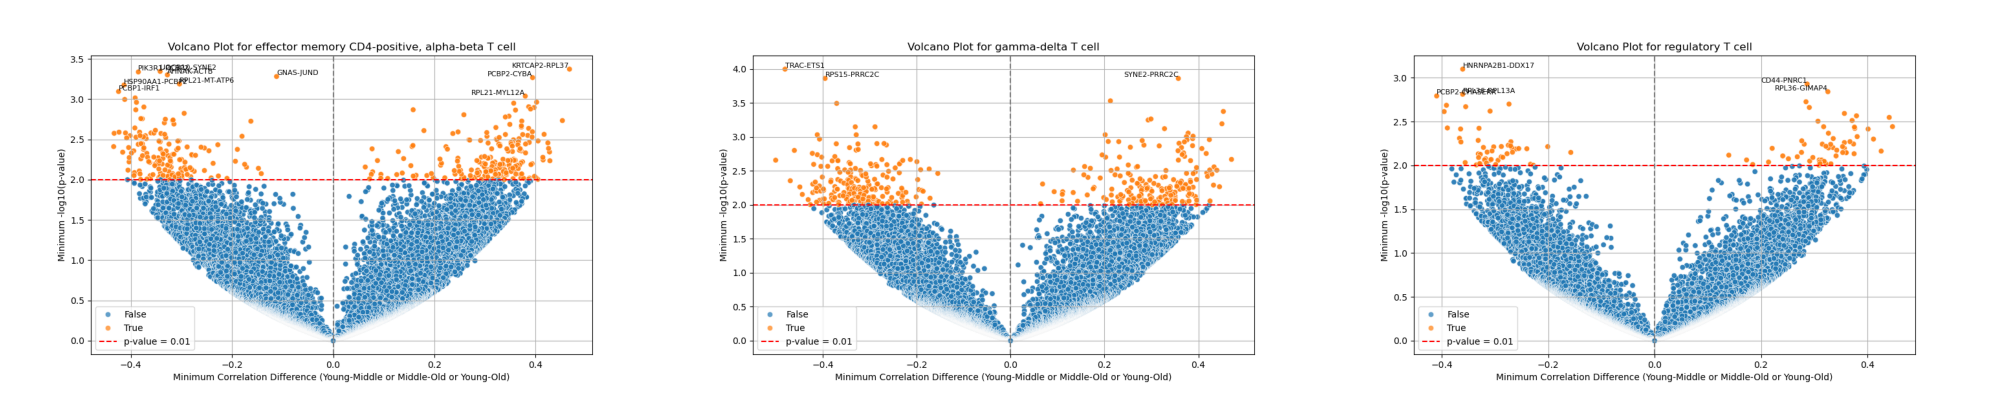

In [6]:
# add the plots together in a single image in a 2x2 grid
import matplotlib.image as mpimg
cell_types = [
    # "CD8-positive, alpha-beta memory T cell",
    # "CD4-positive, alpha-beta T cell",
    # "central memory CD4-positive, alpha-beta T cell",
    "effector memory CD4-positive, alpha-beta T cell",
    "gamma-delta T cell",
    "regulatory T cell",
]
def combine_volcano_plots(cell_types):
    fig, axs = plt.subplots(1, 3, figsize=(20, 15))
    axs = axs.flatten()
    
    for i, cell_type in enumerate(cell_types):
        img = mpimg.imread(f"results/volcano_plot_{cell_type}.png")
        axs[i].imshow(img)
        axs[i].axis('off')
    
    plt.tight_layout()
    # plt.savefig("results/combined_volcano_plots.png")
    plt.show()
    plt.close()

combine_volcano_plots(cell_types)
# Combine the volcano plots into a single image
# and save it as "results/combined_volcano_plots.png"
# The combined image will be a 2x2 grid of the volcano plots


In [10]:
# Set a threshold for the minimum -log10(p-value) and for the minimum correlation difference
threshold_log_p_value = 2
threshold_correlation_diff = 0.4

# Create a new DataFrame for each cell type where we filter the genes based on the thresholds
filtered_genes = {}

for cell_type, df in excel_files_top_diff_genes.items():
    # Ensure the DataFrame has the expected columns
    if 'log_p_value' in df.columns and 'correlation_diff' in df.columns:
        filtered_df = df[(df['log_p_value'] > threshold_log_p_value) & 
                         (np.abs(df['correlation_diff']) > threshold_correlation_diff)]
        filtered_genes[cell_type] = filtered_df[['Gene1', 'Gene2', 'log_p_value', 'correlation_diff', 
                                                  'Correlation Young', 'Correlation Middle', 'Correlation Old']]
        
        # Print the number of rows in the filtered DataFrame
        print(f"{cell_type}: {len(filtered_df) / 2} genes after filtering with thresholds "
              f"log_p_value > {threshold_log_p_value} and correlation_diff > {threshold_correlation_diff}")
        
        # Print all the rows that have a correlation of 0.8 or -0.8 in one of the columns
        for index, row in filtered_df.iterrows():
            if (row['Correlation Young'] >= 0.77 or row['Correlation Middle'] >= 0.77 or 
                row['Correlation Old'] >= 0.77 or row['Correlation Young'] <= -0.77 or 
                row['Correlation Middle'] <= -0.77 or row['Correlation Old'] <= -0.77):
                print(f"Gene1: {row['Gene1']}, Gene2: {row['Gene2']}, "
                      f"Correlation Young: {row['Correlation Young']}, "
                      f"Correlation Middle: {row['Correlation Middle']}, "
                      f"Correlation Old: {row['Correlation Old']}")
    else:
        print(f"Skipping {cell_type} due to missing columns.")

CD8-positive, alpha-beta memory T cell: 14.0 genes after filtering with thresholds log_p_value > 2 and correlation_diff > 0.4
CD4-positive, alpha-beta T cell: 2.0 genes after filtering with thresholds log_p_value > 2 and correlation_diff > 0.4
central memory CD4-positive, alpha-beta T cell: 460.0 genes after filtering with thresholds log_p_value > 2 and correlation_diff > 0.4
Gene1: ENSG00000109332, Gene2: ENSG00000103479, Correlation Young: 0.3039582189821633, Correlation Middle: -0.2290243828891969, Correlation Old: -0.7765657455826811
Gene1: ENSG00000103479, Gene2: ENSG00000109332, Correlation Young: 0.3039582189821634, Correlation Middle: -0.2290243828891968, Correlation Old: -0.7765657455826811
Gene1: ENSG00000166295, Gene2: ENSG00000103479, Correlation Young: -0.2582659901837041, Correlation Middle: 0.1882644319433336, Correlation Old: 0.7878600893917731
Gene1: ENSG00000103479, Gene2: ENSG00000166295, Correlation Young: -0.2582659901837041, Correlation Middle: 0.1882644319433336,

In [31]:
# Get all the distinct genes from the filtered DataFrames
distinct_genes = set()
for cell_type, df in filtered_genes.items():
    distinct_genes.update(df['Gene1'].unique())
    distinct_genes.update(df['Gene2'].unique())

# Print the number of distinct genes
print(f"Number of distinct genes across all cell types: {len(distinct_genes)}")
print(distinct_genes)

# Turn all the distinct genes into a feature names
feature_names = [(adata.var['feature_name'][gene]).split('_')[0] for gene in distinct_genes if gene in adata.var.index]

print(feature_names)

# Save the feature names to a file
with open("results/feature_names.txt", "w") as f:
    for feature in feature_names:
        f.write(f"{feature}\n")


Number of distinct genes across all cell types: 220
{'ENSG00000105193', 'ENSG00000147168', 'ENSG00000131469', 'ENSG00000074800', 'ENSG00000108669', 'ENSG00000203896', 'ENSG00000101745', 'ENSG00000174748', 'ENSG00000159023', 'ENSG00000055163', 'ENSG00000101347', 'ENSG00000005483', 'ENSG00000102317', 'ENSG00000102879', 'ENSG00000110876', 'ENSG00000116824', 'ENSG00000075624', 'ENSG00000153187', 'ENSG00000198840', 'ENSG00000186468', 'ENSG00000182866', 'ENSG00000131507', 'ENSG00000162244', 'ENSG00000179218', 'ENSG00000189067', 'ENSG00000105401', 'ENSG00000076928', 'ENSG00000204592', 'ENSG00000108518', 'ENSG00000133574', 'ENSG00000169442', 'ENSG00000145675', 'ENSG00000161970', 'ENSG00000196405', 'ENSG00000132424', 'ENSG00000184009', 'ENSG00000112306', 'ENSG00000160654', 'ENSG00000137154', 'ENSG00000135486', 'ENSG00000099860', 'ENSG00000211821', 'ENSG00000101608', 'ENSG00000092820', 'ENSG00000111229', 'ENSG00000008517', 'ENSG00000272888', 'ENSG00000144713', 'ENSG00000198771', 'ENSG00000139193

Filtered genes for CD8-positive, alpha-beta memory T cell:
               Gene1            Gene2  log_p_value  correlation_diff  \
12   ENSG00000122026  ENSG00000227507     3.646384          0.412292   
13   ENSG00000227507  ENSG00000122026     3.646384          0.412292   
30   ENSG00000122026  ENSG00000139193     2.692589          0.458553   
31   ENSG00000139193  ENSG00000122026     2.692589          0.458553   
48   ENSG00000074800  ENSG00000137076     3.327873         -0.415007   
49   ENSG00000137076  ENSG00000074800     3.327873         -0.415007   
54   ENSG00000128340  ENSG00000137076     3.177503         -0.449400   
55   ENSG00000137076  ENSG00000128340     3.177503         -0.449400   
66   ENSG00000092010  ENSG00000137076     2.795981         -0.426547   
67   ENSG00000137076  ENSG00000092010     2.795981         -0.426547   
80   ENSG00000122566  ENSG00000076928     2.683420         -0.432227   
81   ENSG00000076928  ENSG00000122566     2.683420         -0.432227   
82   

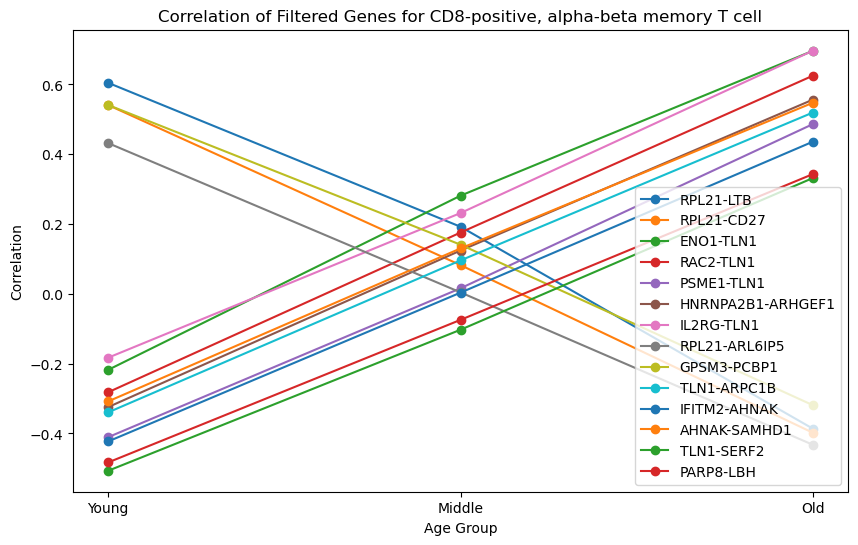

Filtered genes for CD4-positive, alpha-beta T cell:
             Gene1            Gene2  log_p_value  correlation_diff  \
2  ENSG00000147604  ENSG00000197111     3.247339         -0.463415   
3  ENSG00000197111  ENSG00000147604     3.247339         -0.463415   
4  ENSG00000125691  ENSG00000197111     3.228762         -0.439000   
5  ENSG00000197111  ENSG00000125691     3.228762         -0.439000   

   Correlation Young  Correlation Middle  Correlation Old  
2          -0.352208            0.111207         0.585291  
3          -0.352208            0.111207         0.585291  
4          -0.404992            0.034008         0.530578  
5          -0.404992            0.034008         0.530578  




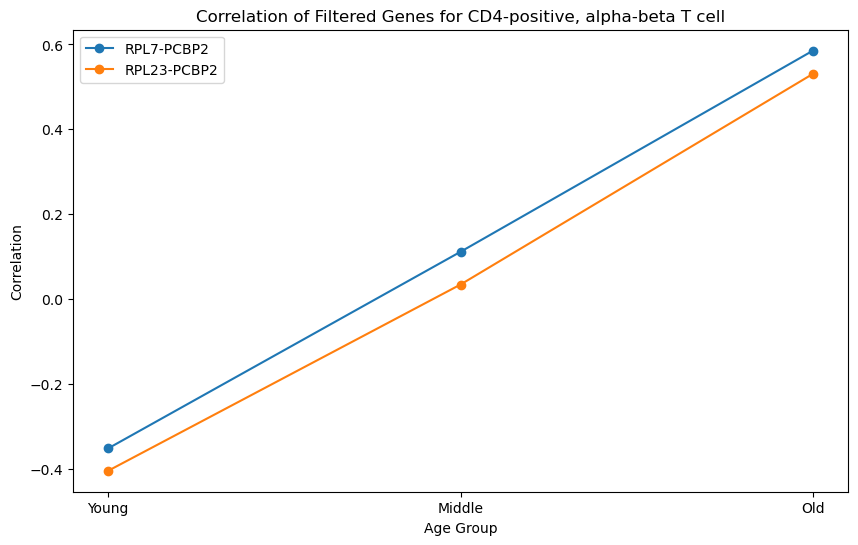

Filtered genes for central memory CD4-positive, alpha-beta T cell:
                Gene1            Gene2  log_p_value  correlation_diff  \
0     ENSG00000175463  ENSG00000122026     4.118753          0.454756   
1     ENSG00000122026  ENSG00000175463     4.118753          0.454756   
2     ENSG00000109332  ENSG00000076928     4.649128          0.499848   
3     ENSG00000076928  ENSG00000109332     4.649128          0.499848   
4     ENSG00000196924  ENSG00000166295     4.363755         -0.419630   
...               ...              ...          ...               ...   
4495  ENSG00000179820  ENSG00000076928     2.123105          0.400593   
4528  ENSG00000116251  ENSG00000196405     2.131730          0.400051   
4529  ENSG00000196405  ENSG00000116251     2.131730          0.400051   
4616  ENSG00000122566  ENSG00000144713     2.695454          0.402249   
4617  ENSG00000144713  ENSG00000122566     2.695454          0.402249   

      Correlation Young  Correlation Middle  Correlation

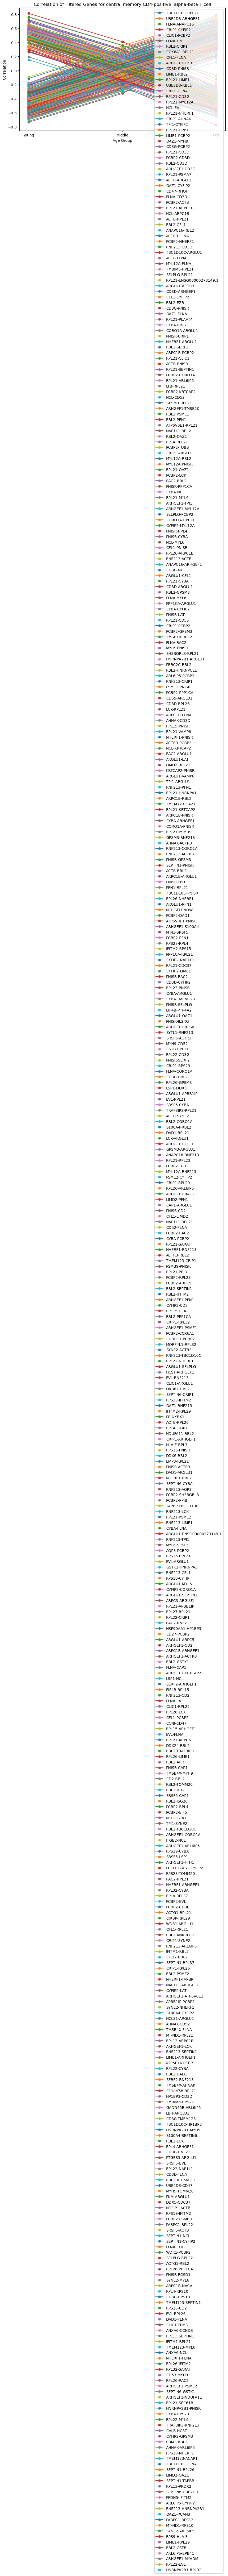

Filtered genes for effector memory CD4-positive, alpha-beta T cell:
               Gene1            Gene2  log_p_value  correlation_diff  \
8    ENSG00000163463  ENSG00000145592     3.372797          0.467250   
9    ENSG00000145592  ENSG00000163463     3.372797          0.467250   
72   ENSG00000080824  ENSG00000197111     3.175845         -0.413574   
73   ENSG00000197111  ENSG00000080824     3.175845         -0.413574   
86   ENSG00000169564  ENSG00000125347     3.094901         -0.424329   
87   ENSG00000125347  ENSG00000169564     3.094901         -0.424329   
108  ENSG00000127528  ENSG00000197111     2.996438         -0.412187   
109  ENSG00000197111  ENSG00000127528     2.996438         -0.412187   
118  ENSG00000169442  ENSG00000162244     2.734100          0.453190   
119  ENSG00000162244  ENSG00000169442     2.734100          0.453190   
122  ENSG00000054654  ENSG00000147168     2.399685         -0.404409   
123  ENSG00000147168  ENSG00000054654     2.399685         -0.404409

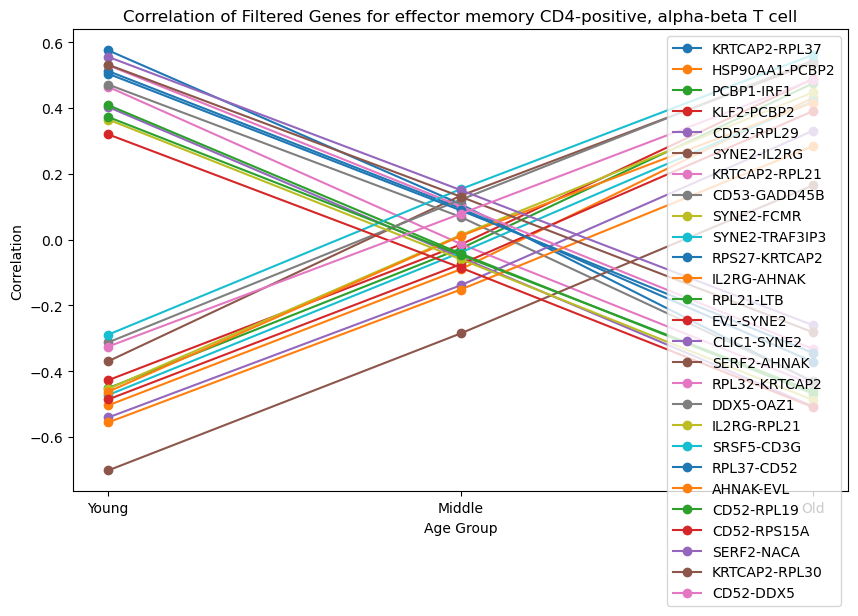

Filtered genes for gamma-delta T cell:
               Gene1            Gene2  log_p_value  correlation_diff  \
4    ENSG00000277734  ENSG00000134954     3.996062         -0.480377   
5    ENSG00000134954  ENSG00000277734     3.996062         -0.480377   
20   ENSG00000146278  ENSG00000136490     2.656515         -0.500321   
21   ENSG00000136490  ENSG00000146278     2.656515         -0.500321   
22   ENSG00000178982  ENSG00000220205     3.030746         -0.411679   
..               ...              ...          ...               ...   
537  ENSG00000120616  ENSG00000108298     2.066166         -0.406805   
574  ENSG00000054654  ENSG00000277734     2.039201         -0.413234   
575  ENSG00000277734  ENSG00000054654     2.039201         -0.413234   
910  ENSG00000273149  ENSG00000198242     2.408103         -0.401034   
911  ENSG00000198242  ENSG00000273149     2.408103         -0.401034   

     Correlation Young  Correlation Middle  Correlation Old  
4            -0.487591           -

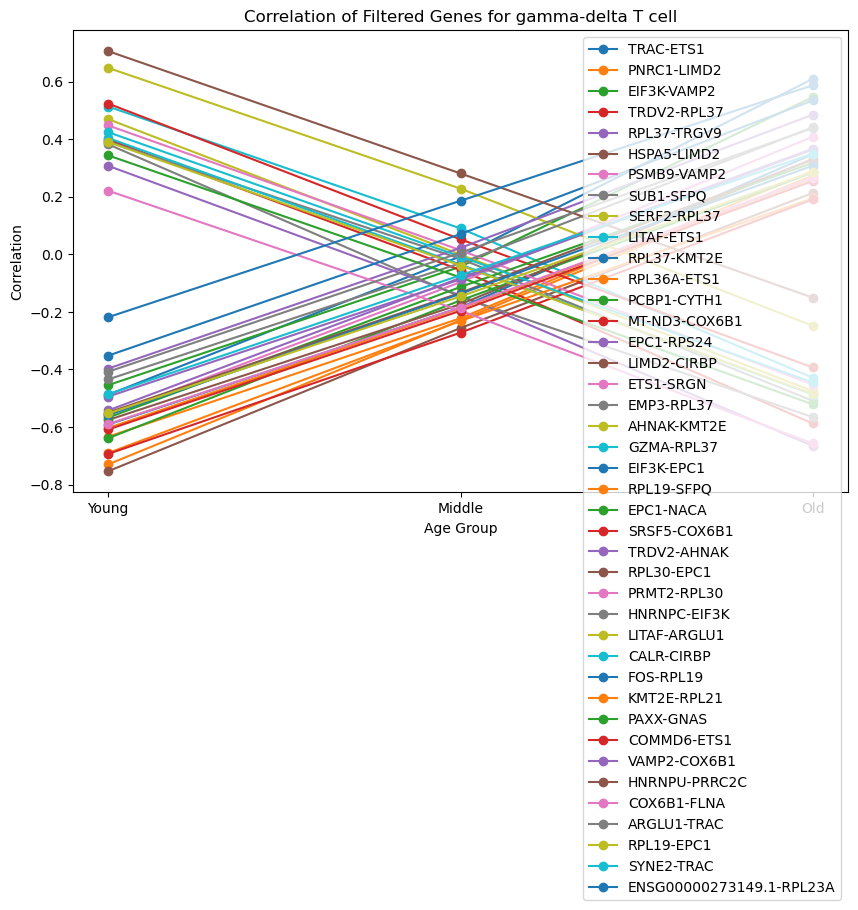

Filtered genes for regulatory T cell:
              Gene1            Gene2  log_p_value  correlation_diff  \
8   ENSG00000197111  ENSG00000272888     2.792104         -0.409579   
9   ENSG00000272888  ENSG00000197111     2.792104         -0.409579   
10  ENSG00000101608  ENSG00000122026     2.442284          0.447181   
11  ENSG00000122026  ENSG00000101608     2.442284          0.447181   
12  ENSG00000204592  ENSG00000272888     2.547370          0.441042   
13  ENSG00000272888  ENSG00000204592     2.547370          0.441042   
30  ENSG00000116251  ENSG00000179144     2.414959          0.401351   
31  ENSG00000179144  ENSG00000116251     2.414959          0.401351   
50  ENSG00000133574  ENSG00000110700     2.163009          0.425858   
51  ENSG00000110700  ENSG00000133574     2.163009          0.425858   
58  ENSG00000170776  ENSG00000132507     2.300207          0.411421   
59  ENSG00000132507  ENSG00000170776     2.300207          0.411421   

    Correlation Young  Correlation Mid

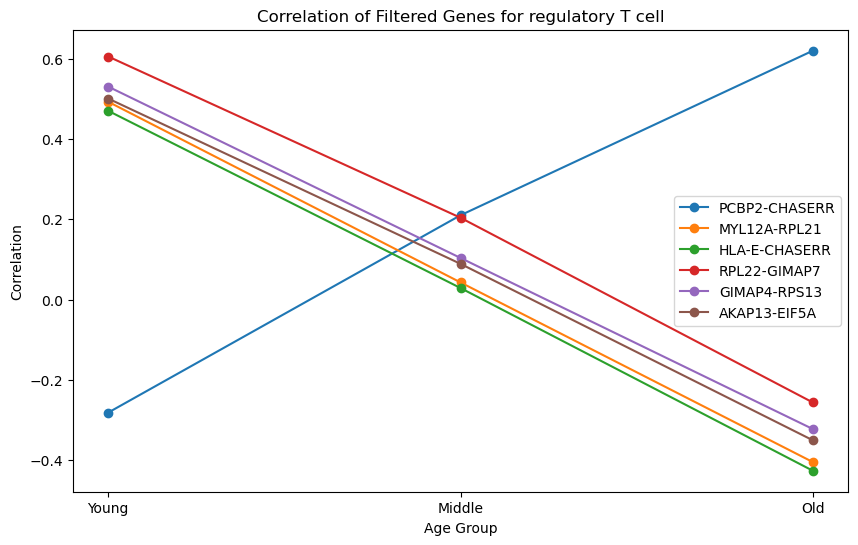

In [ ]:
# Print the filtered genes for each cell type
for cell_type, df in filtered_genes.items():
    print(f"Filtered genes for {cell_type}:")
    print(df)
    print("\n")

    # Plot the young, middle and old correlations for the filtered genes for every even row
    plt.figure(figsize=(10, 6))
    for i in range(0, len(df), 2):
        row = df.iloc[i]
        gene_1 = row['Gene1']
        gene_2 = row['Gene2']
        feature_1 = (adata.var['feature_name'][gene_1]).split('_')[0]
        feature_2 = (adata.var['feature_name'][gene_2]).split('_')[0]
        label_genes = feature_1 + '-' + feature_2
        plt.plot(['Young', 'Middle', 'Old'], 
                 [row['Correlation Young'], row['Correlation Middle'], row['Correlation Old']], 
                 marker='o', label=label_genes)
    plt.title(f'Correlation of Filtered Genes for {cell_type}')
    plt.xlabel('Age Group')
    plt.ylabel('Correlation')
    plt.legend()
    plt.show()